<a href="https://colab.research.google.com/github/jatoogunhyo/dart_disclosure/blob/main/basic_listing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 패키지 Import

In [1]:
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json

# 연도별 기본자료 구하기
상장종목, 시가총액, 거래대금 등 기본자료 구하기

In [2]:
#거래소 홈페이지에서 불러오기
#화면번호 42002(주요통계추이)
start_year = '2000'
end_year = '2023'
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL', # 시장구분
    'pdTpCd': 'Y',
    #'strtDd': '20241122',
    #'endDd': '20241224',
    'strtYy': start_year,
    #'strtMm': '11',
    'endYy': end_year,
    #'endMm': '12',
    'share': '2', # 주식 단위
    'money': '5', # 금액 단위
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/EASY/main/MDCEASY00303'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_listed = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')


In [3]:
df_listed

,연도,회사수,종목수,상장주식수,상장자본금,상장주식시가총액,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균,회전율_상장주식,회전율_시가총액
0,2023,2670,2787,115803780.0,148701175397388,2562011711548156,405979428.0,1657059.0,4809278837889412,19629709542406,354.94,200.46
1,2022,2569,2690,113226353.0,144509621083400,2086643751594151,400890912.0,1629638.0,3914167850272827,15911251423873,362.12,165.79
2,2021,2487,2610,109420568.0,141465222227900,2654829828488724,693356302.0,2795792.0,6768651530131681,27292949718273,664.72,258.34
3,2020,2411,2531,100850720.0,135964968535761,2371736356308052,626832252.0,2527549.0,5709175198444849,23020867735665,642.33,316.70
4,2019,2355,2475,95583171.0,132083797924571,1722585791038533,318740356.0,1295693.0,2288218174314459,9301699895587,346.71,139.21
5,2018,2264,2380,89331611.0,127970827630241,1578460544082467,290624079.0,1191082.0,2800893376366844,11479071214618,349.04,152.46
6,2017,2195,2311,76926480.0,122990333141441,1893469018541703,261485458.0,1076072.0,2190902441153344,9016059428615,355.81,126.12
7,2016,2129,2249,70514379.0,120768528106171,1514271512890129,263537674.0,1071291.0,1948188345428724,7919464818816,395.76,132.41
8,2015,2030,2149,63671443.0,116444935005971,1448410480739801,262845886.0,1059862.0,2201463952211245,8876870775045,432.32,151.65
9,2014,1905,2035,59225137.0,117004667738471,1336765867949191,155004065.0,632670.0,1458804088606287,5954302402475,270.30,110.37


### 코랩 환경에서 시각화에 한글이 깨지지 않도록 조치

In [52]:
# 필요한 라이브러리 설치
!pip install adjustText

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

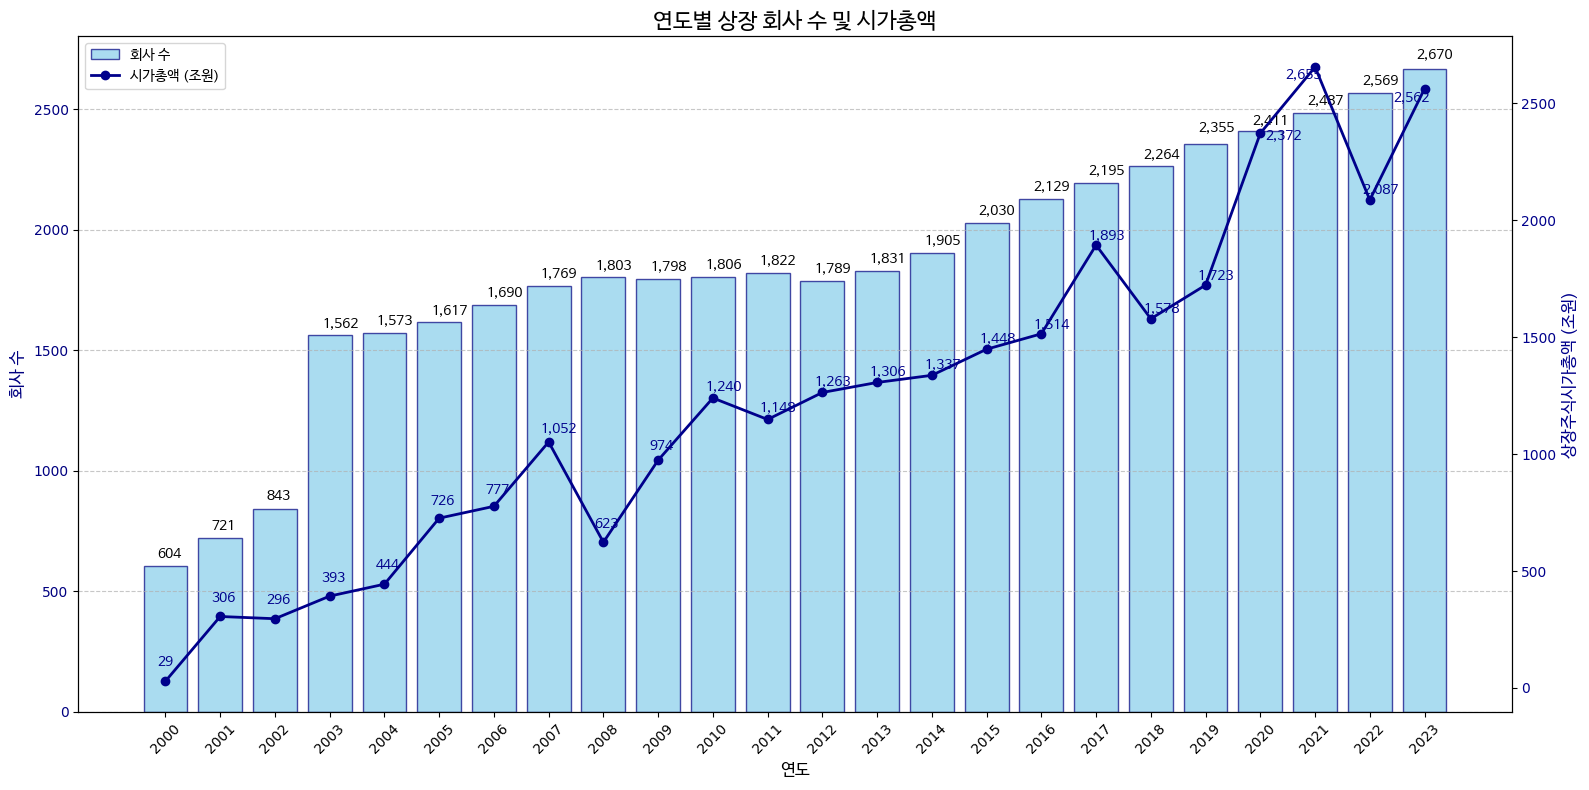

In [24]:
# 시가총액을 조 단위로 변환
df_listed['시가총액_조'] = df_listed['상장주식시가총액'] / 1_000_000_000_000

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(16, 8))

# 회사수 막대 그래프 (주축)
bars = ax1.bar(df_listed['연도'], df_listed['회사수'], color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('회사 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 - 모든 연도 표시
plt.xticks(df_listed['연도'], rotation=45)

# 상장주식시가총액 선 그래프 (보조축)
ax2 = ax1.twinx()
line = ax2.plot(df_listed['연도'], df_listed['시가총액_조'], color='darkblue', linewidth=2, marker='o')
ax2.set_ylabel('상장주식시가총액 (조원)', fontproperties=font, fontsize=12, color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# 그래프 제목 설정
plt.title('연도별 상장 회사 수 및 시가총액', fontproperties=font, fontsize=16)

# 범례 추가 (왼쪽 상단에 함께 표시)
plt.legend([bars, line[0]], ['회사 수', '시가총액 (조원)'], loc='upper left', prop=font)

# 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 텍스트 레이블을 저장할 리스트
texts = []

# 데이터 레이블 추가 (회사 수)
for bar in bars:
    height = bar.get_height()
    texts.append(ax1.text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:,.0f}', ha='center', va='bottom', fontproperties=font))

# 데이터 레이블 추가 (시가총액)
for i, v in enumerate(df_listed['시가총액_조']):
    texts.append(ax2.text(df_listed['연도'][i], v, f'{v:,.0f}', ha='center', va='top', fontproperties=font, color='darkblue'))

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 그래프 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 회사수 막대 그래프
fig.add_trace(
    go.Bar(x=df_listed['연도'], y=df_listed['회사수'], name="회사 수",
           text=df_listed['회사수'], textposition='outside'),
    secondary_y=False,
)

# 시가총액 선 그래프
fig.add_trace(
    go.Scatter(x=df_listed['연도'], y=df_listed['시가총액_조'], name="시가총액 (조원)",
               mode='lines+markers+text', text=df_listed['시가총액_조'].round(0),
               textposition='top center'),
    secondary_y=True,
)

# 레이아웃 설정
fig.update_layout(
    title_text="연도별 상장 회사 수 및 시가총액",
    xaxis_title="연도",
    xaxis=dict(
        tickmode='array',
        tickvals=df_listed['연도'],
        ticktext=df_listed['연도'],
        tickangle=45
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# y축 레이블 설정
fig.update_yaxes(title_text="회사 수", secondary_y=False)
fig.update_yaxes(title_text="상장주식시가총액 (조원)", secondary_y=True)

# 그래프 표시
fig.show()

# 자사주 관련 데이터 수집하기

## 거래소 정보데이터 시스템에서 자사주 취득/처분 통계 불러오기
*장내 수량만 카운트 됨. 장외 자사주 취득은 카운트 안됨

In [ ]:
#거래소 홈페이지에서 불러오기
#화면번호 20004(자사주취득/처분종목현)

gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': '20100101',
    'endDd': '20241224',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20601'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')


In [ ]:
df_buyback.columns

Index(['공시일', '종목코드', '종목명', '시장구분', '직접/신탁', '취득/처분', '취득(처분)예정기간_시작일',
       '취득(처분)예정기간_종료일', '신고내역_수량', '신고내역_금액', '체결내역(누계)_수량',
       '체결내역(누계)_체결수량비율', '체결내역(누계)_금액'],
      dtype='object')

In [ ]:
# prompt: df_listed DataFrame 사용: 연도별 유형별 취득수량/처분수량을 알려줘

import pandas as pd

# Convert the '공시일' column to datetime objects
df_buyback['공시일'] = pd.to_datetime(df_buyback['공시일'])

# Extract the year from the '공시일' column
df_buyback['year'] = df_buyback['공시일'].dt.year

# Group by year, 종목코드, and 거래유형
grouped = df_buyback.groupby(['시장구분','year', '직접/신탁', '취득/처분'])

# Aggregate the '취득/처분' column using sum
result = grouped['체결내역(누계)_수량'].sum().unstack()

# Display the result
result

취득/처분                     처분           취득
시장구분  year 직접/신탁                         
KONEX 2013 신탁       183400.0          NaN
           직접            NaN     113900.0
      2014 신탁            NaN      78310.0
      2015 직접            NaN      40000.0
      2016 신탁            NaN      23511.0
...                      ...          ...
KOSPI 2023 신탁            NaN  142548037.0
           직접      8857547.0   74650467.0
      2024 스톡옵션          NaN     151000.0
           신탁            NaN   97859135.0
           직접     11618600.0  123789148.0

[77 rows x 2 columns]

## 금감원 오픈다트의 웹에서 주요사항보고서(자사주취득) 불러오기
*공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있음

### 0) 검색 기준이 되는 인풋 입력하기

In [75]:
# 사용자 입력 받기
start_y = input('시작연도를 입력하세요(2015년부터 데이터 제공): ')
end_y = input('종료연도를 입력하세요: ')
corp_type_input = input('유, 코, 유코 중에서 하나를 입력하세요 :')

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332"
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

시작연도를 입력하세요(2015년부터 데이터 제공): 2015
종료연도를 입력하세요: 2023
유, 코, 유코 중에서 하나를 입력하세요 :유


{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2023-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2023-12-31',
 'reportCode': '11332',
 'corpType': 'P'}

### 1) 처음 크롤링은 페이지 인덱스 1을 기준으로 하고, 크롤링 결과물에서 페이지가 2이상일 경우 추가로 크롤링을 수행

In [76]:
# 첫번째 페이지 크롤링
req = requests.post(url, params = params)

#### 1-1) 첫번째 페이지 인덱스의 내용을 데이터프레임으로 만들기

In [77]:
# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

### 2) 페이지가 2이상일 경우 추가로 Loop을 통해 크롤링 수행

#### 2-1) 페이지가 2이상일 경우 페이지 개수 확인하기

In [78]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 6
total_counts: 563


#### 2-2) 확인한 페이지 개수대로 loop 돌리기

In [79]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

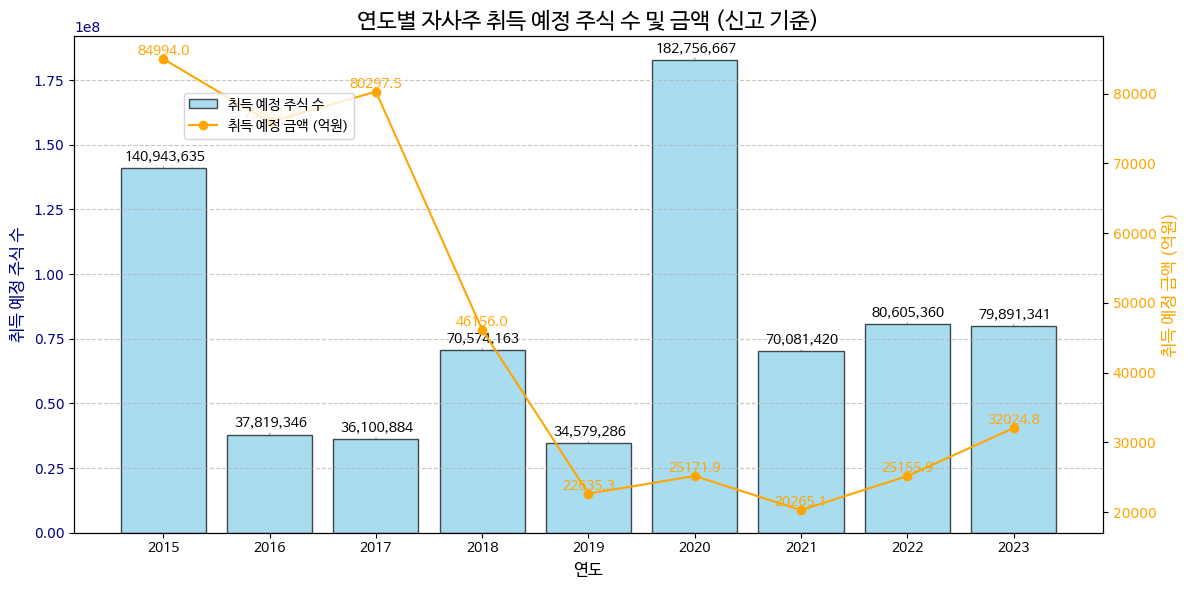

In [80]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일_접수일_접수일'] = pd.to_datetime(df_dart_buyback['접수일_접수일_접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일_접수일_접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식(주)_취득예정주식(주)_보통주식': 'sum',
    '취득예정금액(원)_취득예정금액(원)_보통주식': 'sum'
})

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식']):
    ax2.text(annual_summary.index[i], value, f'{value:.1f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 막대 그래프 레이블 위치 조정
adjust_text(texts, ax=ax1, only_move={'points': 'y', 'texts': 'y'},
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()
